# Importo i pacchetti

In [14]:
import numpy as np 
from filterpy.kalman import KalmanFilter 
import scipy
from scipy.linalg import block_diag
from filterpy.common import Q_discrete_white_noise
import matplotlib.pyplot as plt
from matplotlib import style

%matplotlib inline
style.use('seaborn-paper')

# Kalman Filter Design
Il filtro che per ora sto utilizzando è il classico filtro di Kalman, come venne proposto nel 87.
Mi sono basato sulle classiche equazioni per capire inizialmente come funziona il tutto. In questa simulazione faccio un piccolo test. 


LunaNet utilizza un filtro simile ma con una piccola variazione su come avviene l'update.

In [16]:
kf = KalmanFilter(dim_x = 6, dim_z = 3)

In [18]:
# Offset State Vector:
iX  = 0
iY  = 1
iZ  = 2
iVx = 3
iVy = 4
iVz = 5

# Time step size:
dt = 0.1

# F - Design State Transition Function
State Transition Matrix $\mathbf F$ 
$$\mathbf{\bar x} = \mathbf{F \bar x}$$
State Vector $\mathbf{\bar x}$:
$$\mathbf{\bar x} = \mathbf{[X_c, Y_c, Z_c, V_{xc}, V_{yc}, V_{zc}]}$$

In [19]:
kf.F[iX, iVx] = dt
kf.F[iY, iVy] = dt
kf.F[iZ, iVz] = dt

print(kf.F)

[[1.  0.  0.  0.1 0.  0. ]
 [0.  1.  0.  0.  0.1 0. ]
 [0.  0.  1.  0.  0.  0.1]
 [0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  1. ]]


# Q - Design the Process Noise Matrix
For simplicity I will assume the noise is a discrete time Wiener process - that it is constant for each time period. This assumption allows me to use a variance to specify how much I think the model changes between steps.

In [20]:
q = Q_discrete_white_noise(dim=3, dt=dt, var=0.001)
kf.Q = block_diag(q, q)
print(kf.Q)

[[2.5e-08 5.0e-07 5.0e-06 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-07 1.0e-05 1.0e-04 0.0e+00 0.0e+00 0.0e+00]
 [5.0e-06 1.0e-04 1.0e-03 0.0e+00 0.0e+00 0.0e+00]
 [0.0e+00 0.0e+00 0.0e+00 2.5e-08 5.0e-07 5.0e-06]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-07 1.0e-05 1.0e-04]
 [0.0e+00 0.0e+00 0.0e+00 5.0e-06 1.0e-04 1.0e-03]]


# B - Design the control function
We haven't yet added controls to our SAT, so there is nothing to be done for this step. The KalmanFilter class initializes B to zero under the assumption that there is no control input, so there is no code to write. If you like, you can be explicit and set kf.B to 0, but as you can see it already has that value.

In [21]:
print(kf.B)

None


# H - Design the Measurement function
The measurement function $\mathbf H$ defines how we go from the state variables to the measurements using the equation $\mathbf z = \mathbf{Hx}$. For I start measuring directly the position, so $X_c$, $Y_c$, $Z_c$

In [22]:
kf.H[iX, iX] = 1
kf.H[iZ, iZ] = 1
kf.H[iY, iY] = 1

kf.H

array([[1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.]])

# R - Design the Measurement Noise Matrix

We assume that the $x$,$y$ and $z$ variables are independent white Gaussian processes. That is, the noise in x is not in any way dependent on the noise in y or z, and the noise is normally distributed about the mean 0. For now let's set the variance for $x$ and $y$ and $z$ to be 50 meters.
R is a $3{\times}3$ matrix because we have 3 sensor inputs(XYZ), and covariance matrices are always of size $n{\times}n$ for $n$ variables. In Python we write

In [23]:
kf.R *= 0.05 # KM 
kf.R

array([[0.05, 0.  , 0.  ],
       [0.  , 0.05, 0.  ],
       [0.  , 0.  , 0.05]])

# Initial Conditions
For our problem we will set the initial position at (0,0,0) with a velocity of (1,1,1). Since that is a pure guess, we will set the covariance matrix $\small\mathbf P$ to a large value.

In [24]:
init_x, init_y, init_z, init_vx, init_vy, init_vz = 0., 0, 0, 1, 1, 1
kf.x = np.array([[init_x, init_y, init_z, init_vx, init_vy, init_vz]]).T
kf.u = 0
kf.P = np.eye(6) * 500.


# Implement the Filter

Design is complete, now we just have to write the code to run the filter and output the data in the format of our choice. We will run the code.


In [25]:
N = 60*60* 1 # ORE
# Measurements:
x,y,z = 0., 0, 0
Zs = []
Xs = []
for i in range(N+2):
    x = x + dt*1 + np.random.randn()/30
    y = y + dt*1 + np.random.randn()/30 
    z = z + dt*1 + np.random.randn()/30
    zs = [x,y,z]
    Xs.append(x)
    Zs.append(zs)

In [26]:
mus = []
MES=100
for step in range(N):
    kf.predict()
    if step != 0 and step % MES == 0:
        kf.update(Zs[step+1])
    mus.append(kf.x)

In [27]:
# VALUE PREDICTED:

x_pred = []
for mu in mus:
    x = mu[0]
    x_pred.append(x)

# VALUE TRUE:

x_true = []
x_tmp = 0
for i in range(N):
    x_tmp = x_tmp + 1*dt
    x_true.append(x_tmp)

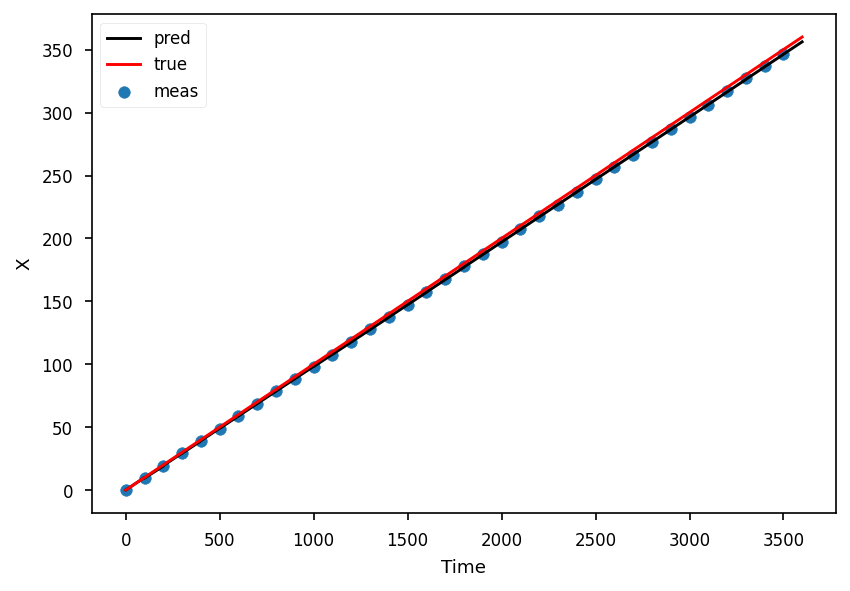

In [28]:
plt.figure(dpi=150)
plt.plot(x_pred, '-k')
plt.scatter([int(i*MES) for i in range(int(N/MES))], [Xs[i*MES] for i in range(int(N/MES))])
plt.plot(x_true, 'r')
plt.legend(['pred','true','meas'])
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

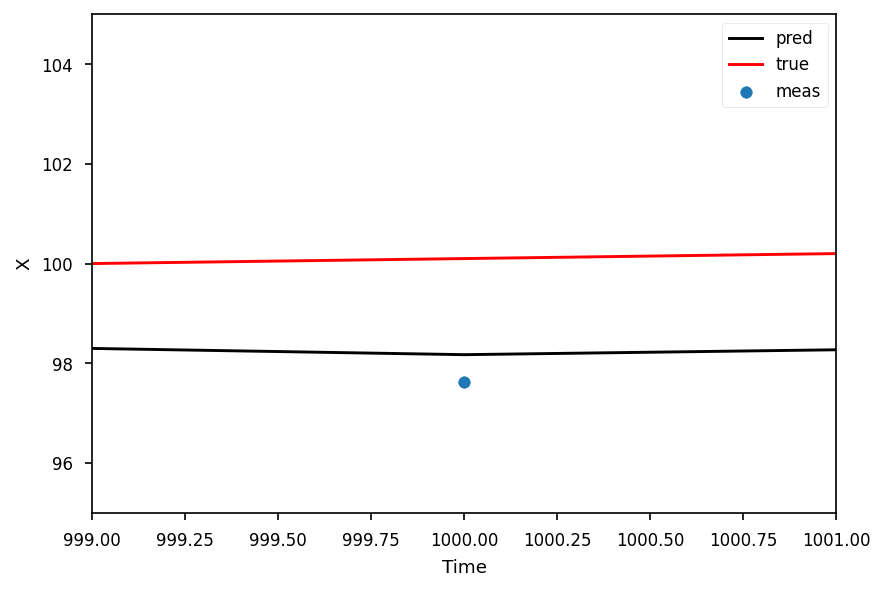

In [29]:
plt.figure(dpi=150)
plt.plot(x_pred, '-k')
plt.scatter([int(i*MES) for i in range(int(N/MES))], [Xs[i*MES] for i in range(int(N/MES))])
plt.plot(x_true, 'r')
plt.legend(['pred','true','meas'])
plt.xlim([1000-1,1000+1])
plt.ylim([100-5,100+5])
plt.xlabel('Time')
plt.ylabel('X')
plt.show()

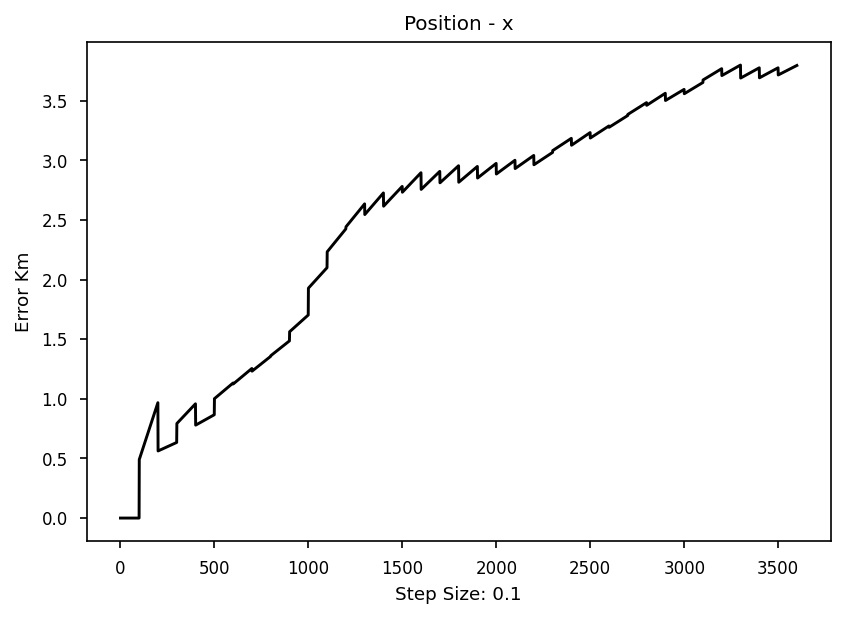

In [30]:
plt.figure(dpi=150)
x_pred = np.array(x_pred)
x_true = np.array(x_true)
diff = []
for x,y in zip(x_pred,x_true):
    d = abs(x - y)
    diff.append(d)
plt.title('Position - x')
plt.plot(diff, '-k')
plt.xlabel(f'Step Size: {dt}')
plt.ylabel('Error Km')
plt.show()